# This notebook stores each step of refactoring the graph data into PSL data

In [1]:
# No space between equals sign is necessary, so we can treat these as Bash variables as well.
FILE_GROUND_TRUTH_EMAIL_NODES='../c3/namata-kdd11-data/enron/enron-samples-lowunk/outputgraph/enron.NODE.email.tab'
FILE_GROUND_TRUTH_COREF_EDGES='../c3/namata-kdd11-data/enron/enron-samples-lowunk/outputgraph/enron.UNDIRECTED.coref.tab'
FILE_GROUND_TRUTH_MANAGES_EDGES='../c3/namata-kdd11-data/enron/enron-samples-lowunk/outputgraph/enron.UNDIRECTED.email-submgr.tab'
FILE_GROUND_TRUTH_COMMUNICATION_EDGES='../c3/namata-kdd11-data/enron/enron-samples-lowunk/outputgraph/enron.DIRECTED.sentto.tab'


FILE_SAMPLE_EMAIL_NODES='../c3/namata-kdd11-data/enron/enron-samples-lowunk/enron-sample-lowunk-1of6/sample-enron.NODE.email.tab'
FILE_SAMPLE_COREF_EDGES='../c3/namata-kdd11-data/enron/enron-samples-lowunk/enron-sample-lowunk-1of6/sample-enron.UNDIRECTED.coref.tab'
FILE_SAMPLE_MANAGES_EDGES='../c3/namata-kdd11-data/enron/enron-samples-lowunk/enron-sample-lowunk-1of6/sample-enron.UNDIRECTED.email-submgr.tab'


## These functions help parse the .tab files.

In [2]:
import pandas as pd
import numpy as np
import re
import itertools # for cross products when filling in a full PSL dataset

In [3]:
# assigns types to each column
def resolve_column_type(table):
    for column in table.columns:
        if column in {'id', 'email', 'alt_email', 'other_email' , 'numsent', 'numreceived', 'numexchanged'}:
            table[column] = table[column].astype(str).astype(float).astype(int)
        # convert bag-of-words columns to floats (since ints won't take NaNs)
        elif re.match("w-", column):
            table[column] = table[column].astype(str).astype(float)

# extracts feature name from an element in a raw tab row
# returns: tuple (feature_name, feature_value, optional_value)
def get_feature_tuple(feature):
    feature_data = re.split(r"[:=]", feature)
    return feature_data
    

# loads the *.tab files into a Pandas Dataframe.
# returns: pd.DataFrame(columns=features)
def load_table(filename):

    # initialize the pandas dataframe
    node_data = pd.DataFrame()


    with open(filename) as infile:
        i = 0
        row_list = []
        for row in infile:
    
            #print('i is: ', i)

            if i == 0:
                # Skip non-useful first line
                print("Header: ", row)
            elif i == 1:
                # Prepare dataframe column labels
                tokens = row.split()
                if len(tokens) == 1:
                    print("This is not a NODE file, so don't load this row")
                else:  
                    features = ["id"] + [get_feature_tuple(feature)[1] for feature in tokens]
                    node_data = pd.DataFrame(columns=features)
            else:
          
                # this is to help the function generalize among the NODE and EDGE files.
                # EDGE files have a "|" character, which needs to be removed for proper feature decoupling
                row = re.sub(r'\|','', row)
            
                tokens = row.split()

                # the first token doesn't need splitting
                row_dict = {'id':tokens[0]}
                row_dict.update({get_feature_tuple(token)[0]:get_feature_tuple(token)[1] for token in tokens[1:]})
                row_list.append(row_dict)
        
            i += 1
        
        # Fill in rows
        node_data = pd.concat([node_data, pd.DataFrame(row_list)], ignore_index=True)

    return node_data

# Process the email nodes

## Get ground truth

In [4]:
email_nodes = load_table(FILE_GROUND_TRUTH_EMAIL_NODES)
# remove the (unnecessary) second to last column (it came from an ambiguous parse splits)
email_nodes.drop('other,manager,specialist,director,executive', axis=1, inplace=True)
resolve_column_type(email_nodes)

email_nodes.dtypes

Header:  NODE	email



id                int64
emailaddress     object
numsent           int64
numreceived       int64
numexchanged      int64
                 ...   
w-kinney        float64
w-veselack      float64
w-mwhitt        float64
w-jarnold       float64
title            object
Length: 5119, dtype: object

In [5]:
email_nodes

,id,emailaddress,numsent,numreceived,numexchanged,w-gerald,w-know,w-busi,w-mexicana,w-transact,...,w-bartlo,w-columbiagassubject,w-perron,w-coh,w-agl,w-kinney,w-veselack,w-mwhitt,w-jarnold,title
0,283,c..koehler@enron.com,128,606,734,1.0,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,director
1,98,scott.goodell@enron.com,98,607,705,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,specialist
2,183,p..south@enron.com,8,351,359,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,director
3,204,lavorato@enron.com,388,3,391,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,executive
4,318,mike.grigsby@enron.com,3702,490,4192,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,executive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,114,vkamins@enron.com,0,12,12,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,director
207,270,david.duran@enron.com,7,145,152,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,director
208,282,sean.crandall@enron.com,94,138,232,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,director
209,243,kevin.presto@enron.com,248,198,446,1.0,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,executive


In [6]:
# Takes a table and fills the missing pairs and values to specify a full, sufficient set
# So far it only works with binary predicates
def fill_observed_missing_possibilities(table, arguments, values):
    total_possibilities = set(itertools.product(list(table[arguments[0]]), values))
    already_observed_possibilities = set((table.loc[index][arguments[0]], table.loc[index][arguments[1]]) for index in table.index)

    missing_possibilities = total_possibilities - already_observed_possibilities
    row_list = []
    for arg_0, arg_1 in missing_possibilities:
        row_dict = {arguments[0]:arg_0, arguments[1]:arg_1, arguments[2]:0 }
        row_list.append(row_dict)
        
    return pd.concat([table, pd.DataFrame(row_list)], ignore_index=True)

In [7]:
# Grab necessary columns, in preparation for dumping the whole ground truth data
email_nodes_data = email_nodes[['id','title']].copy()

# convert titles to integers, so PSL can ground faster
title_map = {"other": 0, "manager": 1, "specialist": 2, "director": 3, "executive": 4}

email_nodes_data = email_nodes_data.replace({'title': title_map})
email_nodes_data['exists'] = 1.0

full_set_email_has_label_data = fill_observed_missing_possibilities(email_nodes_data, ['id', 'title', 'exists'], list(title_map.values()))
full_set_email_has_label_data

,id,title,exists
0,283,3,1.0
1,98,2,1.0
2,183,3,1.0
3,204,4,1.0
4,318,4,1.0
...,...,...,...
1050,182,4,0.0
1051,308,0,0.0
1052,46,0,0.0
1053,202,0,0.0


In [8]:
# Outputs all data (obs+truth)
# full_set_email_has_label_data.to_csv('EmailHasLabel_data.csv', sep ='\t', index=False, header=False, columns=['id', 'title', 'exists'])

## Calculate splits for PSL predicates

In [9]:
# Grab the sample from the original experiment, this will allow us to calculate observations and targets.
sample_email_nodes = load_table(FILE_SAMPLE_EMAIL_NODES)
# remove the (unnecessary) second to last column (it came from an ambiguous parse splits)
sample_email_nodes.drop('other,manager,specialist,director,executive', axis=1, inplace=True)
resolve_column_type(sample_email_nodes)

Header:  NODE	email



In [10]:
# Split data into observed and targets (AKA train and test)
email_nodes_obs = email_nodes[email_nodes['id'].isin(sample_email_nodes[sample_email_nodes['title'].notna()]['id'])]
email_nodes_truth = email_nodes[email_nodes['id'].isin(sample_email_nodes[sample_email_nodes['title'].isna()]['id'])]

In [11]:
# Grab the necessary columns
email_has_label_obs = email_nodes_obs[['id','title']].copy()
email_has_label_truth = email_nodes_truth[['id','title']].copy()

# convert titles to integers, so PSL can ground faster
email_has_label_obs = email_has_label_obs.replace({'title': title_map})
email_has_label_truth = email_has_label_truth.replace({'title': title_map})

# add in an existence column
email_has_label_obs['exists'] = 1.0
email_has_label_truth['exists'] = 1.0

# email_has_label_obs

In [12]:
# Add in the the non existent observations
full_set_email_has_label_obs = fill_observed_missing_possibilities(email_has_label_obs, ['id', 'title', 'exists'], list(title_map.values()))
full_set_email_has_label_truth = fill_observed_missing_possibilities(email_has_label_truth, ['id', 'title', 'exists'], list(title_map.values()))

In [13]:
# Outputs splits to file
# full_set_email_has_label_obs.to_csv('EmailHasLabel_obs.csv', sep ='\t', index=False, header=False)
# full_set_email_has_label_truth.to_csv('EmailHasLabel_truth.csv', sep ='\t', index=False, header=False)

# Process the CoRef edges

## Get ground truth

In [14]:
# need to rename one of the columns due to key collision
# use copy for safety

!cp $FILE_GROUND_TRUTH_COREF_EDGES .
!sed -i 's/email/alt_email/2g' enron.UNDIRECTED.coref.tab

coref_edges = load_table('enron.UNDIRECTED.coref.tab')
resolve_column_type(coref_edges)

coref_edges.dtypes

Header:  UNDIRECTED	coref

This is not a NODE file, so don't load this row


id            int64
email         int64
alt_email     int64
exists       object
dtype: object

In [15]:
coref_edges

,id,email,alt_email,exists
0,2856,265,141,NOTEXIST
1,18491,310,295,NOTEXIST
2,516,272,183,NOTEXIST
3,5131,201,19,NOTEXIST
4,12417,138,78,NOTEXIST
...,...,...,...,...
20776,15003,135,208,NOTEXIST
20777,4450,197,47,NOTEXIST
20778,20302,248,25,NOTEXIST
20779,12985,222,118,NOTEXIST


In [16]:
# Grab necessary columns, in preparation for dumping the whole ground truth data
coref_edges_data = coref_edges[['email','alt_email', 'exists']].copy()

# convert existence column to boolean, so PSL can ground faster
exists_map = {"NOTEXIST": 0.0, "EXIST": 1.0}
coref_edges_data = coref_edges_data.replace({'exists': exists_map})

# Since it's undirected, add in the reverse edges.
coref_edges_data_sym = coref_edges_data[['alt_email', 'email', 'exists']].copy()
coref_edges_data_sym.rename(columns = {'alt_email':'email', 'email':'alt_email'}, inplace = True)

coref_edges_data = pd.concat([coref_edges_data, coref_edges_data_sym])

# Calculated the missing edges that were blocked.
missing_edges = {pair for pair in itertools.permutations(email_nodes['id'], 2)} - {pair for pair in zip(coref_edges_data['email'], coref_edges_data['alt_email'])}

# add in the missing edges
row_list = []
for email, alt_email in missing_edges:
    row_dict = {'email':email, 'alt_email':alt_email, 'exists':0 }
    row_list.append(row_dict)

full_set_coref_edges_data = pd.concat([coref_edges_data, pd.DataFrame(row_list)], ignore_index=True)

In [17]:
# Outputs to file
# full_set_coref_edges_data.to_csv('CoRef_data.csv', sep ='\t', index=False, header=False, columns=['email', 'alt_email', 'exists'])

In [18]:
# Sanity Check: These should print pairs of the same people
# for index in full_set_coref_edges_data[full_set_coref_edges_data['exists'] == 1.0][['email', 'alt_email']].index:
#     email_id  = full_set_coref_edges_data.loc[index]['email'].iloc[0]
#     alt_email_id = full_set_coref_edges_data.loc[index]['alt_email'].iloc[0]
    
#     print(email_nodes[email_nodes['id'] == email_id]['emailaddress'])
#     print(email_nodes[email_nodes['id'] == alt_email_id]['emailaddress'])
#     print("------------------------------------------------")
    

## Calculate splits for PSL predicates

In [19]:
# Grab the sample from the original experiment, this will allow us to calculate observations and targets.
sample_coref_edges = load_table(FILE_SAMPLE_COREF_EDGES)
resolve_column_type(sample_coref_edges)


Header:  UNDIRECTED	coref

This is not a NODE file, so don't load this row


In [20]:
# Split data into observed and targets (AKA train and test)
coref_edges_obs = coref_edges[coref_edges['id'].isin(sample_coref_edges[sample_coref_edges['exists'].notna()]['id'])]
coref_edges_truth = coref_edges[coref_edges['id'].isin(sample_coref_edges[sample_coref_edges['exists'].isna()]['id'])]

In [21]:
# Grab the necessary columns
coref_obs = coref_edges_obs[['email', 'alt_email', 'exists']].copy()
coref_truth = coref_edges_truth[['email', 'alt_email', 'exists']].copy()

# convert existence column to boolean, so PSL can ground faster
coref_obs = coref_obs.replace({'exists': exists_map})
coref_truth = coref_truth.replace({'exists': exists_map})

# Since it's undirected, add in the reverse edges.
coref_obs_sym = coref_obs[['alt_email', 'email', 'exists']].copy()
coref_truth_sym = coref_truth[['alt_email', 'email', 'exists']].copy()

coref_obs_sym.rename(columns = {'alt_email':'email', 'email':'alt_email'}, inplace = True)
coref_truth_sym.rename(columns = {'alt_email':'email', 'email':'alt_email'}, inplace = True)

coref_obs = pd.concat([coref_obs, coref_obs_sym], ignore_index=True)
coref_truth = pd.concat([coref_truth, coref_truth_sym], ignore_index=True)

# Calculated the missing edges that were blocked. Note the last set prevents cross contamination
missing_edges = {pair for pair in itertools.permutations(email_nodes['id'], 2)} - {pair for pair in zip(coref_obs['email'], coref_obs['alt_email'])} - {pair for pair in zip(coref_truth['email'], coref_truth['alt_email'])}

# add in the missing edges
row_list = []
for email, alt_email in missing_edges:
    row_dict = {'email':email, 'alt_email':alt_email, 'exists':0 }
    row_list.append(row_dict)

full_set_coref_edges_obs = pd.concat([coref_obs, pd.DataFrame(row_list)], ignore_index=True)

In [22]:
# Outputs splits to file
# full_set_coref_edges_obs.to_csv('CoRef_obs.csv', sep ='\t', index=False, header=False, columns=['email', 'alt_email', 'exists'])
# coref_truth.to_csv('CoRef_truth.csv', sep ='\t', index=False, header=False, columns=['email', 'alt_email', 'exists'])

# Process the Manager edges

## Get ground truth

In [23]:
# Load in the observed email-submgr.
# need to rename one of the columns due to key collision
# use copy for safety
!cp $FILE_GROUND_TRUTH_MANAGES_EDGES .
!sed -i 's/\temail/\tother_email/2g' enron.UNDIRECTED.email-submgr.tab

manager_edges = load_table('enron.UNDIRECTED.email-submgr.tab')

# FIXME: can probably omit this line
manager_edges.drop('NOTEXIST,EXIST', axis=1, inplace=True)

resolve_column_type(manager_edges)

manager_edges.dtypes

Header:  UNDIRECTED	email-submgr



id                int64
w-gerald        float64
w-know          float64
w-busi          float64
w-mexicana      float64
                 ...   
w-jarnold       float64
numexchanged      int64
email             int64
other_email       int64
exists           object
Length: 5118, dtype: object

In [24]:
manager_edges

,id,w-gerald,w-know,w-busi,w-mexicana,w-transact,w-want,w-thing,w-review,w-questar,...,w-coh,w-agl,w-kinney,w-veselack,w-mwhitt,w-jarnold,numexchanged,email,other_email,exists
0,2693,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6,286,324,EXIST
1,2634,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,74,37,NOTEXIST
2,1256,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14,148,131,NOTEXIST
3,1406,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,57,313,EXIST
4,3129,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,43,34,236,NOTEXIST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,2105,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13,67,288,NOTEXIST
2047,2374,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,237,198,212,NOTEXIST
2048,3464,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,210,160,NOTEXIST
2049,531,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9,316,188,NOTEXIST


In [25]:
# Grab necessary columns, in preparation for dumping the whole ground truth data
manager_edges_data = manager_edges[['email','other_email', 'exists']].copy()

# convert existence column to boolean, so PSL can ground faster
manager_edges_data = manager_edges_data.replace({'exists': exists_map})

# Since it's undirected, add in the reverse edges.
manager_edges_data_sym = manager_edges_data[['other_email', 'email', 'exists']].copy()
manager_edges_data_sym.rename(columns = {'other_email':'email', 'email':'other_email'}, inplace = True)

manager_edges_data = pd.concat([manager_edges_data, manager_edges_data_sym])

# Calculated the missing edges that were blocked.
missing_edges = {pair for pair in itertools.permutations(email_nodes['id'], 2)} - {pair for pair in zip(manager_edges_data['email'], manager_edges_data['other_email'])}

# add in the missing edges
row_list = []
for email, other_email in missing_edges:
    row_dict = {'email':email, 'other_email':other_email, 'exists':0 }
    row_list.append(row_dict)

full_set_manager_edges_data = pd.concat([manager_edges_data, pd.DataFrame(row_list)], ignore_index=True)


In [26]:
# Outputs to file
# full_set_manager_edges_data.to_csv('Manages_data.csv', sep ='\t', index=False, header=False, columns=['email', 'other_email', 'exists'])

## Calculate splits for PSL predicates 

In [27]:
# Grab the sample from the original experiment, this will allow us to calculate observations and targets.
sample_manager_edges = load_table(FILE_SAMPLE_MANAGES_EDGES)
resolve_column_type(sample_manager_edges)

Header:  UNDIRECTED	email-submgr



In [28]:
# Split data into observed and targets (AKA train and test)
manager_edges_obs = manager_edges[manager_edges['id'].isin(sample_manager_edges[sample_manager_edges['exists'].notna()]['id'])]
manager_edges_truth = manager_edges[manager_edges['id'].isin(sample_manager_edges[sample_manager_edges['exists'].isna()]['id'])]

In [29]:
print(len(manager_edges_obs))
print(len(manager_edges_truth))

1642
409


In [30]:
# Grab the necessary columns
manages_obs = manager_edges_obs[['email', 'other_email', 'exists']].copy()
manages_truth = manager_edges_truth[['email', 'other_email', 'exists']].copy()

# convert existence column to boolean, so PSL can ground faster
manages_obs = manages_obs.replace({'exists': exists_map})
manages_truth = manages_truth.replace({'exists': exists_map})

# Since it's undirected, add in the reverse edges.
manages_obs_sym = manages_obs[['other_email', 'email', 'exists']].copy()
manages_truth_sym = manages_truth[['other_email', 'email', 'exists']].copy()

manages_obs_sym.rename(columns = {'other_email':'email', 'email':'other_email'}, inplace = True)
manages_truth_sym.rename(columns = {'other_email':'email', 'email':'other_email'}, inplace = True)

manages_obs = pd.concat([manages_obs, manages_obs_sym])
manages_truth = pd.concat([manages_truth, manages_truth_sym])

# Calculated the missing edges that were blocked. Note the last set prevents cross contamination
missing_edges = {pair for pair in itertools.permutations(email_nodes['id'], 2)} - {pair for pair in zip(manages_obs['email'], manages_obs['other_email'])} - {pair for pair in zip(manages_truth['email'], manages_truth['other_email'])}

# add in the missing edges
row_list = []
for email, other_email in missing_edges:
    row_dict = {'email':email, 'other_email':other_email, 'exists':0 }
    row_list.append(row_dict)

full_set_manages_obs = pd.concat([manages_obs, pd.DataFrame(row_list)], ignore_index=True)

In [31]:
# full_set_manages_obs.to_csv('Manages_obs.csv', sep ='\t', index=False, header=False, columns=['email', 'other_email', 'exists'])
# manages_truth.to_csv('Manages_truth.csv', sep ='\t', index=False, header=False, columns=['email', 'other_email', 'exists'])

# Train a local classifier/model

In [32]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

## Node Labeling

In [33]:
email_nodes_obs

,id,emailaddress,numsent,numreceived,numexchanged,w-gerald,w-know,w-busi,w-mexicana,w-transact,...,w-bartlo,w-columbiagassubject,w-perron,w-coh,w-agl,w-kinney,w-veselack,w-mwhitt,w-jarnold,title
0,283,c..koehler@enron.com,128,606,734,1.0,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,director
1,98,scott.goodell@enron.com,98,607,705,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,specialist
2,183,p..south@enron.com,8,351,359,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,director
3,204,lavorato@enron.com,388,3,391,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,executive
4,318,mike.grigsby@enron.com,3702,490,4192,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,executive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,310,jay.reitmeyer@enron.com,55,529,584,1.0,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,other
206,114,vkamins@enron.com,0,12,12,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,director
207,270,david.duran@enron.com,7,145,152,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,director
208,282,sean.crandall@enron.com,94,138,232,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,director


In [34]:
train_x = email_nodes_obs.drop(['id', 'emailaddress', 'title', 'numsent', 'numreceived', 'numexchanged'], axis = 1).fillna(0)
train_y = email_nodes_obs['title']

test_x = email_nodes_truth.drop(['id', 'emailaddress', 'title', 'numsent', 'numreceived', 'numexchanged'], axis = 1).fillna(0)
test_y = email_nodes_truth['title']

In [35]:
# classifier = svm.LinearSVC()
classifier = LogisticRegression(max_iter=300)
classifier.fit(train_x, train_y)

LogisticRegression(max_iter=300)

In [36]:
predictions = classifier.predict(test_x)

In [37]:
classifier.score(test_x, test_y)

0.45

In [38]:
predictions

array(['director', 'director', 'director', 'director', 'specialist',
       'executive', 'director', 'specialist', 'director', 'manager',
       'director', 'specialist', 'other', 'manager', 'specialist',
       'director', 'director', 'director', 'manager', 'director',
       'director', 'specialist', 'specialist', 'director', 'specialist',
       'director', 'executive', 'specialist', 'executive', 'director',
       'other', 'executive', 'director', 'executive', 'executive',
       'executive', 'manager', 'specialist', 'director', 'director'],
      dtype=object)

In [39]:
# title_map = {"other": 0, "manager": 1, "specialist": 2, "director": 3, "executive": 4}

classifier.classes_

array(['director', 'executive', 'manager', 'other', 'specialist'],
      dtype=object)

### Use probabilities for PSL observed data.

In [40]:
local_EmailHasTitle_probabilities = classifier.predict_proba(test_x)

In [41]:
local_EmailHasTitle_obs = pd.DataFrame()
row_list = []
# build a table
for index, probabilities in enumerate(local_EmailHasTitle_probabilities):
    for class_index, probability in enumerate(probabilities):
        row_dict = {'id': email_nodes_truth.iloc[index]['id'], 'title': title_map[classifier.classes_[class_index]], 'exists': probability}
        row_list.append(row_dict)
        #print(email_nodes_truth.iloc[index]['id'], "\t", title_map[classifier.classes_[class_index]], "\t", probability)

local_EmailHasTitle_obs = pd.concat([local_EmailHasTitle_obs, pd.DataFrame(row_list)], ignore_index=True)

In [42]:
# local_EmailHasTitle_obs.to_csv('Local_EmailHasLabel_obs.csv', sep ='\t', index=False, header=False, columns=['id', 'title', 'exists'])

## Link Prediction

In [43]:
manager_edges_obs

,id,w-gerald,w-know,w-busi,w-mexicana,w-transact,w-want,w-thing,w-review,w-questar,...,w-coh,w-agl,w-kinney,w-veselack,w-mwhitt,w-jarnold,numexchanged,email,other_email,exists
0,2693,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6,286,324,EXIST
1,2634,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,74,37,NOTEXIST
4,3129,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,43,34,236,NOTEXIST
5,1344,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13,24,170,NOTEXIST
6,989,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,313,195,318,NOTEXIST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,1716,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8,303,283,NOTEXIST
2046,2105,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13,67,288,NOTEXIST
2048,3464,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,210,160,NOTEXIST
2049,531,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9,316,188,NOTEXIST


In [44]:
train_x = manager_edges_obs.drop(['id', 'numexchanged', 'email', 'other_email', 'exists'], axis = 1).fillna(0)
train_y = manager_edges_obs['exists']

test_x = manager_edges_truth.drop(['id', 'numexchanged', 'email', 'other_email', 'exists'], axis = 1).fillna(0)
test_y = manager_edges_truth['exists']

In [45]:
train_x.dtypes

w-gerald      float64
w-know        float64
w-busi        float64
w-mexicana    float64
w-transact    float64
               ...   
w-agl         float64
w-kinney      float64
w-veselack    float64
w-mwhitt      float64
w-jarnold     float64
Length: 5113, dtype: object

In [46]:
classifier = LogisticRegression(max_iter=300)
classifier.fit(train_x, train_y)

LogisticRegression(max_iter=300)

In [47]:
predictions = classifier.predict(test_x)

In [48]:
classifier.score(test_x, test_y)

0.9070904645476773

### Use probabilities for PSL observed data.

In [49]:
local_Manages_probabilities = classifier.predict_proba(test_x)

In [50]:
local_Manages_obs = pd.DataFrame()
row_list = []
# build a table
for index, probabilities in enumerate(local_Manages_probabilities):
    row_dict = {'email': manager_edges_truth.iloc[index]['email'], 'other_email': manager_edges_truth.iloc[index]['other_email'], 'exists': exists_map[classifier.classes_[np.argmax(probabilities)]]}
    row_list.append(row_dict)
    #print(email_nodes_truth.iloc[index]['id'], "\t", title_map[classifier.classes_[class_index]], "\t", probability)

local_Manages_obs = pd.concat([local_Manages_obs, pd.DataFrame(row_list)])

In [51]:
local_Manages_obs

,email,other_email,exists
0,148,131,0.0
1,57,313,0.0
2,267,249,0.0
3,304,208,0.0
4,186,193,0.0
...,...,...,...
404,104,137,0.0
405,207,172,0.0
406,318,46,0.0
407,101,208,0.0


In [52]:
# Since it's undirected, add in the reverse edges.
local_Manages_obs_sym = local_Manages_obs[['other_email', 'email', 'exists']].copy()

local_Manages_obs_sym.rename(columns = {'other_email':'email', 'email':'other_email'}, inplace = True)

local_Manages_obs = pd.concat([local_Manages_obs, local_Manages_obs_sym])


In [53]:
# local_Manages_obs.to_csv('Local_Manages_obs.csv', sep ='\t', index=False, header=False, columns=['email', 'other_email', 'exists'])

## Entity Resolution

In [54]:
from strsimpy.qgram import QGram
from scipy.spatial import distance

qgram = QGram(1)

node_to_email = dict(zip(email_nodes['id'], email_nodes['emailaddress']))


In [55]:
# Calculate features for Training set

train_x = full_set_coref_edges_obs.copy()

train_x['address_similarity'] = 0.0
train_x['bow_cosine_similarity'] = 0.0
train_x['bow_jaccard_similarity'] = 0.0


for index in train_x.index:
    string_similarity = qgram.distance(node_to_email[train_x.iloc[index]['email']], node_to_email[train_x.iloc[index]['alt_email']])
    train_x.loc[index, 'address_similarity'] = string_similarity

    bow_cosine_similarity = distance.cosine(np.nan_to_num(list(email_nodes[email_nodes['id'] == train_x.iloc[index]['email']].iloc[0][5:-1])), np.nan_to_num(list(email_nodes[email_nodes['id'] == train_x.iloc[index]['alt_email']].iloc[0][5:-1])))
    train_x.loc[index, 'bow_cosine_similarity'] = bow_cosine_similarity

    bow_jaccard_similarity = distance.jaccard(np.nan_to_num(list(email_nodes[email_nodes['id'] == train_x.iloc[index]['email']].iloc[0][5:-1])), np.nan_to_num(list(email_nodes[email_nodes['id'] == train_x.iloc[index]['alt_email']].iloc[0][5:-1])))
    train_x.loc[index, 'bow_jaccard_similarity'] = bow_jaccard_similarity
    

train_x = train_x.drop(['email', 'alt_email', 'exists'], axis = 1)
train_y = full_set_coref_edges_obs['exists'].copy()

In [56]:
# Test set

test_x = coref_truth.copy()
test_y = coref_truth['exists'].copy()

test_x['address_similarity'] = 0.0
test_x['bow_cosine_similarity'] = 0.0
test_x['bow_jaccard_similarity'] = 0.0

for index in test_x.index:
    string_similarity = qgram.distance(node_to_email[test_x.iloc[index]['email']], node_to_email[test_x.iloc[index]['alt_email']])
    test_x.loc[index, 'address_similarity'] = string_similarity

    bow_cosine_similarity = distance.cosine(np.nan_to_num(list(email_nodes[email_nodes['id'] == test_x.iloc[index]['email']].iloc[0][5:-1])), np.nan_to_num(list(email_nodes[email_nodes['id'] == test_x.iloc[index]['alt_email']].iloc[0][5:-1])))
    test_x.loc[index, 'bow_cosine_similarity'] = bow_cosine_similarity

    bow_jaccard_similarity = distance.jaccard(np.nan_to_num(list(email_nodes[email_nodes['id'] == test_x.iloc[index]['email']].iloc[0][5:-1])), np.nan_to_num(list(email_nodes[email_nodes['id'] == test_x.iloc[index]['alt_email']].iloc[0][5:-1])))
    test_x.loc[index, 'bow_jaccard_similarity'] = bow_jaccard_similarity
    
test_x = test_x.drop(['email', 'alt_email', 'exists'], axis = 1)
test_y = coref_truth['exists'].copy()


In [57]:
classifier = LogisticRegression()
classifier.fit(train_x, train_y)

LogisticRegression()

In [58]:
classifier.score(test_x, test_y)

0.9959095283926853

In [59]:
predictions = classifier.predict(test_x)

In [60]:
f1_score(test_y, predictions)

0.4137931034482759

### Use probabilities for PSL observed data.

In [61]:
coref_truth

,email,alt_email,exists
0,177,288,0.0
1,174,56,0.0
2,107,131,0.0
3,1,271,0.0
4,323,163,0.0
...,...,...,...
8307,266,151,0.0
8308,124,207,0.0
8309,212,15,0.0
8310,328,80,0.0


In [62]:
local_CoRef_probabilities = classifier.predict_proba(test_x)

In [63]:
local_CoRef_obs = pd.DataFrame()
row_list = []
# build a table
for index, probabilities in enumerate(local_CoRef_probabilities):
    row_dict = {'email': int(coref_truth.iloc[index]['email']), 'alt_email': int(coref_truth.iloc[index]['alt_email']), 'exists': probabilities[1]}
    row_list.append(row_dict)
    #print(email_nodes_truth.iloc[index]['id'], "\t", title_map[classifier.classes_[class_index]], "\t", probability)

local_CoRef_obs = pd.concat([local_CoRef_obs, pd.DataFrame(row_list)], ignore_index=True)

In [64]:
# local_CoRef_obs.to_csv('Local_CoRef_obs.csv', sep ='\t', index=False, header=False, columns=['email', 'alt_email', 'exists'])

In [65]:
# Sanity check the positive instances
set_1 = {(pair[0], pair[1]) for pair in zip(local_CoRef_obs[local_CoRef_obs['exists'] > 0.5]['email'], local_CoRef_obs[local_CoRef_obs['exists'] > 0.5]['alt_email'])}
set_2 = {(pair[0], pair[1]) for pair in zip(coref_truth[coref_truth['exists'] == 1]['email'], coref_truth[coref_truth['exists'] == 1]['alt_email'])}
set_2 & set_1

{(46, 47),
 (47, 46),
 (137, 138),
 (138, 137),
 (150, 152),
 (152, 150),
 (235, 236),
 (236, 235),
 (254, 259),
 (259, 254),
 (325, 326),
 (326, 325)}

# Calculate Similarity Metrics

## Entity Resolution

### Email Address similarity

In [66]:

# qgram = QGram(1)
# print(qgram.distance('ABCD', 'ABCE'))
email_nodes[email_nodes['id'] == 268]['emailaddress'].iloc[0]

'laura.luce@enron.com'

In [67]:
email_pairs = {pair for pair in itertools.combinations(email_nodes['id'], 2)}

qgram = QGram(1)

sim_email = pd.DataFrame()
row_list = []

for pair in email_pairs:
    #print(pair)

    email_1 = email_nodes[email_nodes['id'] == pair[0]]['emailaddress'].iloc[0]
    email_2 = email_nodes[email_nodes['id'] == pair[1]]['emailaddress'].iloc[0]    
        
    string_similarity = qgram.distance(email_1, email_2)

    row_dict = {'email':pair[0], 'other_email':pair[1], 'qgram_sim':string_similarity}
    row_list.append(row_dict)
    
sim_email = pd.concat([sim_email, pd.DataFrame(row_list)])

In [68]:
# Sanity Check, this should print mostly "exists=1.0"

# for pair in zip(sim_email[sim_email['qgram_sim'] < 5]['email'], sim_email[sim_email['qgram_sim'] < 5]['other_email']):
#     print(full_set_coref_edges_data[(full_set_coref_edges_data['email'] == pair[0]) & (full_set_coref_edges_data['alt_email'] == pair[1])]['exists'])
#     print("--------")

### Bag of words similarity

In [69]:
# These similarity features will be used for PSL predicates instead of a local classifier.
from scipy.spatial import distance
from matplotlib import pyplot as plt

In [70]:
sim_bow = pd.DataFrame()
row_list = []


for pair in email_pairs:
    entity_1 = email_nodes[email_nodes['id'] == pair[0]]
    entity_2 = email_nodes[email_nodes['id'] == pair[1]]
    
    bow_1 = entity_1.iloc[0][5:-1]
    bow_2 = entity_2.iloc[0][5:-1]
    # FIXME: Jaccard distance needs to be on sets
    row_dict = {'email':pair[0], 'other_email':pair[1], 'jaccard_sim_bow':distance.jaccard(list(bow_1), list(bow_2)), 'cosine_sim_bow':distance.cosine(np.nan_to_num(list(bow_1)), np.nan_to_num(list(bow_2)))}
    row_list.append(row_dict)
    
sim_bow = pd.concat([sim_bow, pd.DataFrame(row_list)])


In [71]:
sim_bow['jaccard_sim_bow'].describe()

count    22155.000000
mean         0.863022
std          0.121956
min          0.188539
25%          0.796010
50%          0.885781
75%          0.971054
max          1.000000
Name: jaccard_sim_bow, dtype: float64

In [72]:
sim_bow['cosine_sim_bow'].describe()

count    22155.000000
mean         0.585444
std          0.195204
min          0.060462
25%          0.442353
50%          0.547103
75%          0.734201
max          1.000000
Name: cosine_sim_bow, dtype: float64

In [73]:
# Since it's undirected, add in the reverse edges.
sim_bow_sym = sim_bow[['other_email', 'email', 'jaccard_sim_bow', 'cosine_sim_bow']].copy()
sim_bow_sym.rename(columns = {'other_email':'email', 'email':'other_email'}, inplace = True)

sim_bow = pd.concat([sim_bow, sim_bow_sym])

In [74]:
# sim_bow.to_csv('Sim_Jaccard_Bow.csv', sep ='\t', index=False, header=False, columns=['email', 'other_email', 'jaccard_sim_bow'])

In [75]:
# sim_bow.to_csv('Sim_Cosine_Bow.csv', sep ='\t', index=False, header=False, columns=['email', 'other_email', 'cosine_sim_bow'])

### Network Based silmilarity

In [76]:
# Load in the observed communication network
# need to rename one of the columns due to key collision
# use copy for safety
!cp $FILE_GROUND_TRUTH_COMMUNICATION_EDGES .
!sed -i 's/\temail/\tother_email/2g' enron.DIRECTED.sentto.tab

communication_edges = load_table('enron.DIRECTED.sentto.tab')

# FIXME: can probably omit this line
# manager_edges.drop('NOTEXIST,EXIST', axis=1, inplace=True)

resolve_column_type(communication_edges)

communication_edges.dtypes

Header:  DIRECTED	sentto

This is not a NODE file, so don't load this row


id              int64
email           int64
other_email     int64
numexchanged    int64
dtype: object

In [77]:
communication_edges

,id,email,other_email,numexchanged
0,2856,291,136,2
1,1937,299,1,1
2,516,316,14,3
3,1049,207,188,4
4,5131,174,318,18
...,...,...,...,...
2832,3497,117,243,4
2833,3665,198,219,129
2834,2831,25,291,1
2835,1462,202,280,10


In [78]:
# Add in existence
communication_edges['exists'] = 1.0

# Calculated the missing edges that were blocked.
missing_edges = {pair for pair in itertools.permutations(email_nodes['id'], 2)} - {pair for pair in zip(communication_edges['email'], communication_edges['other_email'])}
# add in the missing edges
row_list = []
for email, alt_email in missing_edges:
    row_dict = {'email':email, 'other_email':alt_email, 'exists':0 }
    row_list.append(row_dict)

full_set_communication_edges = pd.concat([communication_edges, pd.DataFrame(row_list)], ignore_index=True)

In [79]:
# full_set_communication_edges.to_csv('Communicates.csv', sep ='\t', index=False, header=False, columns=['email', 'other_email', 'exists'])

In [80]:
sim_network = pd.DataFrame()
row_list = []


for id_1, id_2 in email_pairs:
    
    adjacent_nodes_1 = set(communication_edges[communication_edges['email'] == id_1]['other_email'])
    adjacent_nodes_2 = set(communication_edges[communication_edges['email'] == id_2]['other_email'])

    #print(adjacent_nodes_1)
    #print(adjacent_nodes_2)

    jaccard_sim =  len(adjacent_nodes_1 & adjacent_nodes_2) / len(adjacent_nodes_1 | adjacent_nodes_2 ) if len(adjacent_nodes_1 | adjacent_nodes_2) != 0 else 0
    dice_sim =  (2 * len(adjacent_nodes_1 & adjacent_nodes_2) ) / (len(adjacent_nodes_1) + len(adjacent_nodes_2)) if len(adjacent_nodes_1) + len(adjacent_nodes_2) != 0 else 0
    
    # dice_sim = 
    
    row_dict = {'email':id_1, 'other_email':id_2, 'jaccard_sim_network':jaccard_sim, 'dice_sim_network':dice_sim}
    row_list.append(row_dict)
    
sim_network = pd.concat([sim_network, pd.DataFrame(row_list)])
    

In [81]:
# Since it's undirected, add in the reverse edges.
sim_network_sym = sim_network[['other_email', 'email', 'jaccard_sim_network', 'dice_sim_network']].copy()
sim_network_sym.rename(columns = {'other_email':'email', 'email':'other_email'}, inplace = True)

sim_network = pd.concat([sim_network, sim_network_sym], ignore_index=True)

In [82]:
sim_network

,email,other_email,jaccard_sim_network,dice_sim_network
0,132,268,0.000000,0.000000
1,266,268,0.000000,0.000000
2,185,279,0.000000,0.000000
3,160,222,0.022222,0.043478
4,220,273,0.034483,0.066667
...,...,...,...,...
44305,83,138,0.000000,0.000000
44306,201,229,0.000000,0.000000
44307,150,303,0.157895,0.272727
44308,47,14,0.000000,0.000000


In [83]:
duplicates = {(pair[0], pair[1]) for pair in zip(full_set_coref_edges_data[full_set_coref_edges_data['exists'] == 1.0]['email'], full_set_coref_edges_data[full_set_coref_edges_data['exists'] == 1.0]['alt_email'])}

In [84]:
filtered_frame = pd.DataFrame()
row_list = []

for index in sim_network.index:
    if (sim_network.iloc[index]['email'], sim_network.iloc[index]['other_email']) in duplicates:
        row_dict = {'email': sim_network.iloc[index]['email'], 'other_email': sim_network.iloc[index]['other_email'], "jaccard_sim_network": sim_network.iloc[index]['jaccard_sim_network'], "dice_sim_network": sim_network.iloc[index]['dice_sim_network']}
        row_list.append(row_dict)
        
filtered_frame = pd.concat([filtered_frame, pd.DataFrame(row_list)], ignore_index=True)

In [85]:
filtered_frame["jaccard_sim_network"].describe()

count    212.000000
mean       0.073877
std        0.142050
min        0.000000
25%        0.000000
50%        0.000000
75%        0.133333
max        0.816327
Name: jaccard_sim_network, dtype: float64

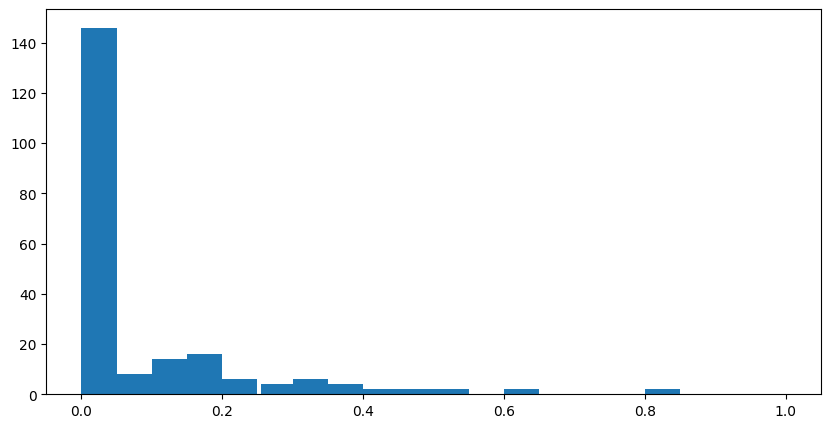

In [86]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))
axis.hist(filtered_frame["jaccard_sim_network"], bins = [0, 0.05, 0.1, 0.15, .20, 0.25, 0.255, 0.30, 0.35, 0.40, 0.50, 0.55, .60, 0.65, 0.70, 0.75, .80, 0.85, 0.90, 0.95, 1.00])
# Displaying the graph
plt.show()

In [87]:
sim_network["jaccard_sim_network"].describe()

count    44310.000000
mean         0.033539
std          0.070383
min          0.000000
25%          0.000000
50%          0.000000
75%          0.040000
max          1.000000
Name: jaccard_sim_network, dtype: float64

In [88]:
filtered_frame["dice_sim_network"].describe()

count    212.000000
mean       0.112360
std        0.194552
min        0.000000
25%        0.000000
50%        0.000000
75%        0.235294
max        0.898876
Name: dice_sim_network, dtype: float64

In [89]:
# sim_network.to_csv('Sim_Jaccard_Network.csv', sep ='\t', index=False, header=False, columns=['email', 'other_email', 'jaccard_sim_network'])

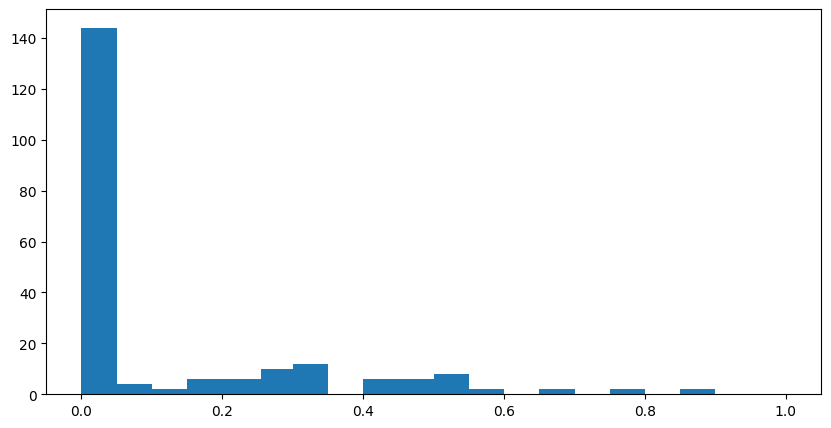

In [90]:
fig, axis = plt.subplots(figsize = (10, 5))
axis.hist(filtered_frame["dice_sim_network"], bins = [0, 0.05, 0.1, 0.15, .20, 0.25, 0.255, 0.30, 0.35, 0.40, 0.50, 0.55, .60, 0.65, 0.70, 0.75, .80, 0.85, 0.90, 0.95, 1.00] )
# Displaying the graph
plt.show()

In [91]:
# TODO: why isn't this printing mostly "exists"?
# for pair in zip(sim_network[sim_network['jaccard_sim_network'] > 0.5]['email'], sim_network[sim_network['jaccard_sim_network'] > 0.5]['other_email']):
#     print(full_set_coref_edges_data[(full_set_coref_edges_data['email'] == pair[0]) & (full_set_coref_edges_data['alt_email'] == pair[1])]['exists'])
#     print("--------")

In [92]:
# TODO: why isn't this printing mostly "exists"?
# for pair in zip(sim_network[sim_network['jaccard_sim_network'] > 0.5]['email'], sim_network[sim_network['jaccard_sim_network'] > 0.5]['other_email']):
#     print(full_set_coref_edges_data[(full_set_coref_edges_data['email'] == pair[0]) & (full_set_coref_edges_data['alt_email'] == pair[1])]['exists'])
#     print("--------")